In [54]:
import logging
from pathlib import Path
from typing import Dict

import mlflow
import numpy as np
import pandas as pd
from dotenv import dotenv_values
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# from config import logger
from lib.data_handling import CustomSpectralPipeline, load_split_data  # type: ignore
from lib.norms import Norm1Scaler, Norm3Scaler
from lib.outlier_removal import (
    calculate_leverage_residuals,
    identify_outliers,
    plot_leverage_residuals,
)
from lib.reproduction import (
    major_oxides,
    masks,
    optimized_blending_ranges,
    oxide_ranges,
    paper_individual_sm_rmses,
    spectrometer_wavelength_ranges,
    training_info,
)
from lib.utils import custom_kfold_cross_validation, filter_data_by_compositional_range
from PLS_SM.inference import predict_composition_with_blending

env = dotenv_values()
comp_data_loc = env.get("COMPOSITION_DATA_PATH")
dataset_loc = env.get("DATA_PATH")

if not comp_data_loc:
    print("Please set COMPOSITION_DATA_PATH in .env file")
    exit(1)

if not dataset_loc:
    print("Please set DATA_PATH in .env file")
    exit(1)

logger = logging.getLogger("train")

mlflow.set_tracking_uri("http://localhost:5000")

preformatted_data_path = Path("../data/_preformatted_sm/")
train_path = preformatted_data_path / "train.csv"
test_path = preformatted_data_path / "test.csv"

if (
    not preformatted_data_path.exists()
    or not train_path.exists()
    or not test_path.exists()
):
    take_samples = None

    logger.info("Loading data from location: %s", dataset_loc)
    # data = load_data(str(dataset_loc))
    train_data, test_data = load_split_data(
        str(dataset_loc), split_loc="../train_test_split.csv", average_shots=True
    )
    logger.info("Data loaded successfully.")

    logger.info("Initializing CustomSpectralPipeline.")
    pipeline = CustomSpectralPipeline(
        masks=masks,
        composition_data_loc=comp_data_loc,
        major_oxides=major_oxides,
    )
    logger.info("Pipeline initialized. Fitting and transforming data.")
    train_processed = pipeline.fit_transform(train_data)
    test_processed = pipeline.fit_transform(test_data)
    logger.info("Data processing complete.")

    preformatted_data_path.mkdir(parents=True, exist_ok=True)

    train_processed.to_csv(train_path, index=False)
    test_processed.to_csv(test_path, index=False)
else:
    logger.info("Loading preformatted data from location: %s", preformatted_data_path)
    train_processed = pd.read_csv(train_path)
    test_processed = pd.read_csv(test_path)

In [55]:
train_processed.shape

(1538, 5495)

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(5485, 1024) # First layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout for regularization
        self.fc2 = nn.Linear(1024, 512)  # Second layer
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, 256)   # Third layer
        self.fc4 = nn.Linear(256, 128)   # Fourth layer
        self.fc5 = nn.Linear(128, 8)     # Output layer with 8 variables

    def forward(self, x):
        # Forward pass
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x) # No activation, linear output
        return x

# Initialize the model
model = RegressionNet()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model summary
print(model)

RegressionNet(
  (fc1): Linear(in_features=5485, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=8, bias=True)
)


In [57]:
from lib.reproduction import major_oxides

In [58]:
train_processed.head()

,246.688,246.741,246.79401,246.847,246.89999,246.953,247.007,247.06,247.11301,247.166,...,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,Sample Name,ID
0,2.439570e+11,2.246847e+11,1.961482e+11,1.644633e+11,1.492086e+11,1.570229e+11,1.792450e+11,2.016259e+11,2.122715e+11,2.118636e+11,...,64.41,0.62,15.44,5.66,1.74,0.78,4.26,2.98,g3mt,g3mt_2013_10_16_145555_ccs
1,2.626729e+11,2.400213e+11,2.050276e+11,1.658918e+11,1.472473e+11,1.577285e+11,1.846657e+11,2.095429e+11,2.195410e+11,2.166893e+11,...,64.41,0.62,15.44,5.66,1.74,0.78,4.26,2.98,g3mt,g3mt_2013_10_16_150213_ccs
2,2.282879e+11,2.067940e+11,1.777004e+11,1.451188e+11,1.288624e+11,1.369983e+11,1.591943e+11,1.809021e+11,1.909366e+11,1.906016e+11,...,64.41,0.62,15.44,5.66,1.74,0.78,4.26,2.98,g3mt,g3mt_2013_10_16_145912_ccs
3,4.759072e+11,4.417126e+11,3.986048e+11,3.485546e+11,3.248000e+11,3.355618e+11,3.654832e+11,3.975601e+11,4.118502e+11,4.085931e+11,...,64.41,0.62,15.44,5.66,1.74,0.78,4.26,2.98,g3mt,g3mt_2013_10_16_145428_ccs
4,3.403353e+11,3.158465e+11,2.835478e+11,2.471903e+11,2.302594e+11,2.388690e+11,2.631144e+11,2.873468e+11,2.966626e+11,2.933021e+11,...,64.41,0.62,15.44,5.66,1.74,0.78,4.26,2.98,g3mt,g3mt_2013_10_16_150042_ccs


In [59]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True

In [60]:
from sklearn.model_selection import train_test_split

train_cols = train_processed.columns
test_cols = test_processed.columns

scaler = (
    Norm1Scaler(reshaped=True)
    # if norm == 1
    # else 
    # Norm3Scaler(spectrometer_wavelength_ranges, reshaped=True)
)

train = scaler.fit_transform(train_processed)
test = scaler.fit_transform(test_processed)

# turn back into dataframe
train = pd.DataFrame(train, columns=train_cols)
test = pd.DataFrame(test, columns=test_cols)

drop_cols = major_oxides + ["ID", "Sample Name"]

# Splitting the training data into training and validation sets
X = train.drop(columns=drop_cols).to_numpy()
y = train[major_oxides].to_numpy()

# Split ratio: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting test set
X_test = test.drop(columns=drop_cols).to_numpy()
y_test = test[major_oxides].to_numpy()

# Convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [61]:
# Train the model
num_epochs = 10000
batch_size = 32
losses = []
val_losses = []

early_stopping = EarlyStopping(patience=100, min_delta=0.01)

# Train the model
for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # Early stopping logic
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch [10/10000], Loss: 472.3046, Val Loss: 476.9783
Epoch [20/10000], Loss: 344.2424, Val Loss: 316.7406
Epoch [30/10000], Loss: 115.9277, Val Loss: 99.3240
Epoch [40/10000], Loss: 69.5703, Val Loss: 71.2912
Epoch [50/10000], Loss: 52.0534, Val Loss: 51.1002
Epoch [60/10000], Loss: 46.8556, Val Loss: 47.8993
Epoch [70/10000], Loss: 43.1678, Val Loss: 44.3621
Epoch [80/10000], Loss: 41.0854, Val Loss: 42.3558
Epoch [90/10000], Loss: 39.6498, Val Loss: 40.7951
Epoch [100/10000], Loss: 38.0988, Val Loss: 39.3452
Epoch [110/10000], Loss: 36.6961, Val Loss: 38.1597
Epoch [120/10000], Loss: 35.4383, Val Loss: 37.2575
Epoch [130/10000], Loss: 34.8315, Val Loss: 36.5969
Epoch [140/10000], Loss: 34.0224, Val Loss: 36.1190
Epoch [150/10000], Loss: 33.7597, Val Loss: 35.8462
Epoch [160/10000], Loss: 33.4682, Val Loss: 35.6253
Epoch [170/10000], Loss: 33.2881, Val Loss: 35.5200
Epoch [180/10000], Loss: 32.9822, Val Loss: 35.3956
Epoch [190/10000], Loss: 32.9147, Val Loss: 35.2494
Epoch [200/10000

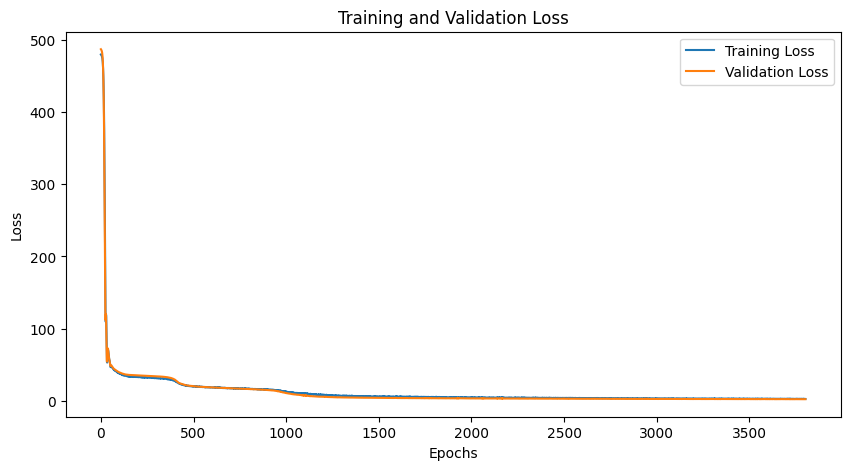

Loss: 4.8330


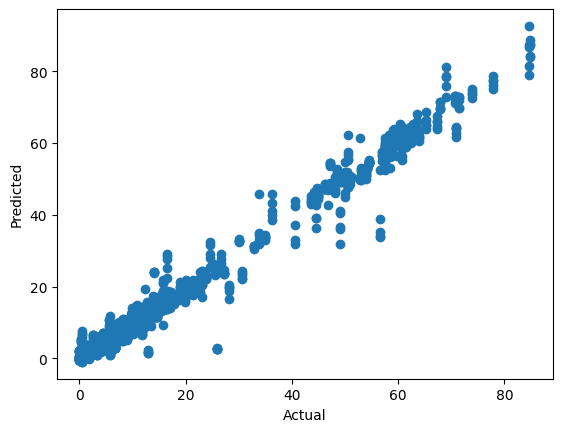

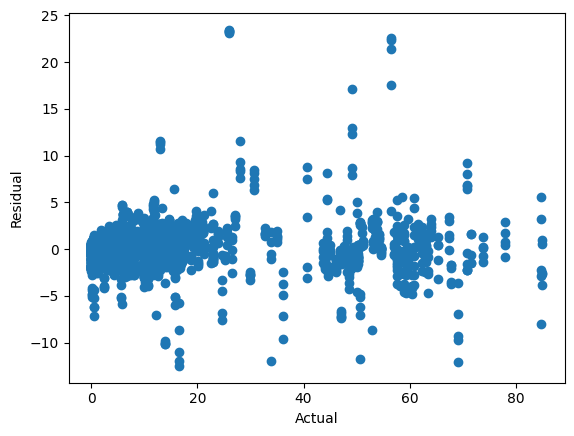

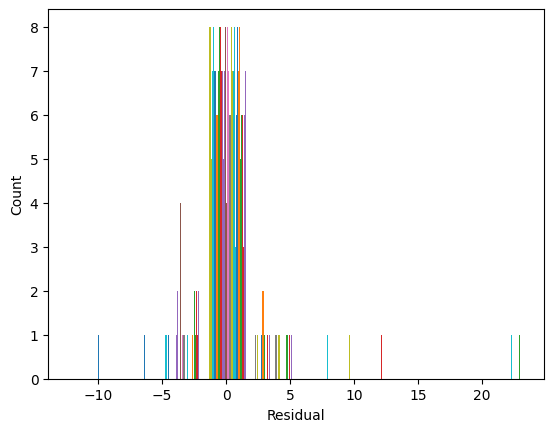

In [62]:
# Plot the loss curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the model
with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    print(f'Loss: {loss:.4f}')
    
    # Plot predictions vs actual
    plt.scatter(y_test, outputs)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    
    # Plot the residuals
    plt.scatter(y_test, y_test-outputs)
    plt.xlabel('Actual')
    plt.ylabel('Residual')
    plt.show()
    
    # Plot the residuals histogram
    plt.hist(y_test-outputs)
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()

In [63]:
# calculate RMSEs
rmse = np.sqrt(mean_squared_error(y_test, outputs))
print("RMSE: ", rmse)

RMSE:  2.198403


In [64]:
# rmse for each oxide
rmse_oxides = np.sqrt(mean_squared_error(y_test, outputs, multioutput="raw_values"))
# as dataframe
rmse_oxides = pd.DataFrame(rmse_oxides, index=major_oxides, columns=["RMSE"])

In [65]:
rmse_oxides

,RMSE
SiO2,3.681658
TiO2,0.566382
Al2O3,2.465062
FeOT,2.629155
MgO,1.036286
CaO,1.324127
Na2O,2.871607
K2O,0.852112


In [66]:
paper=5.3+1.03+3.47+2.31+2.21+2.72+0.62+0.82
this=rmse_oxides.sum()

(paper/8), round((sum(this)/8), 2)

(2.31, 1.93)